# Assignment 2


In [ ]:
# importing necessary libraries
import numpy as np
import pandas as pd

In [ ]:
# mounting the google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/NLP dataset/Dataset.csv')
df

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1
...,...,...
5786,Industry body CII said #discoms are likely to ...,-1
5787,"#Gold prices slip below Rs 46,000 as #investor...",-1
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1


In [ ]:
import string
import re

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from nltk.stem import PorterStemmer
ps = PorterStemmer()

sw_nltk = stopwords.words('english')
def cleaning_data(data):
    cnt = 0
    aux_list = []
    for sentence in data:
        word_list = []
        for word in sentence.split():
            word = word.lower()         #converting to lower case
            if (word not in sw_nltk):   #if not a stop word
                text = ps.stem(word)    #apply stemming
                word_list.append(text)
        aux_list.append(' '.join(word_list))
    return aux_list

X = cleaning_data(df['Text'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
y = df['Sentiment']

*Feature Selection (1/3)*

# BoW (Bag of Words)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1, shuffle=True)

In [ ]:
#CountVectorizer is used to represent the words as a list of values, instead of text
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

vectorizer.fit(X)
X_train = vectorizer.transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y)
y_train = le.transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)


In [ ]:
X_train = X_train.toarray()
X_test = X_test.toarray()
X_val = X_val.toarray()

In [ ]:
dummy = pd.DataFrame(X_train)
dummy

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,8884,8885,8886,8887,8888,8889,8890,8891,8892,8893,8894,8895,8896,8897,8898,8899,8900,8901,8902,8903,8904,8905,8906,8907,8908,8909,8910,8911,8912,8913,8914,8915,8916,8917,8918,8919,8920,8921,8922,8923
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3700,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3701,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3702,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3703,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
num_of_features = X_test.shape[1]
print('Total number of features: ', num_of_features)

Total number of features:  8924


In [ ]:
print('Total training data: ', X_train.shape[0])
print('Total validation data:  ', X_val.shape[0])
print('Total testing data:  ', X_test.shape[0])

Total training data:  3705
Total validation data:   927
Total testing data:   1159


In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


# Neural Networks Model

In [ ]:
#import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

model = Sequential()
model.add(Dense(units=256, activation='relu', input_dim=len(vectorizer.get_feature_names_out())))
model.add(Dropout(0.2))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))
opt = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', f1_m, precision_m, recall_m])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F-1 Score:", f1_score)

Epoch 1/10
116/116 [==============================] - 4s 21ms/step - loss: 0.5467 - accuracy: 0.7236 - f1_m: 0.7888 - precision_m: 0.7530 - recall_m: 0.8432 - val_loss: 0.4728 - val_accuracy: 0.7778 - val_f1_m: 0.8346 - val_precision_m: 0.7843 - val_recall_m: 0.8961
Epoch 2/10
116/116 [==============================] - 2s 19ms/step - loss: 0.2383 - accuracy: 0.9074 - f1_m: 0.9262 - precision_m: 0.9186 - recall_m: 0.9386 - val_loss: 0.6123 - val_accuracy: 0.7724 - val_f1_m: 0.8204 - val_precision_m: 0.8232 - val_recall_m: 0.8239
Epoch 3/10
116/116 [==============================] - 2s 19ms/step - loss: 0.0693 - accuracy: 0.9741 - f1_m: 0.9791 - precision_m: 0.9802 - recall_m: 0.9791 - val_loss: 0.9267 - val_accuracy: 0.7724 - val_f1_m: 0.8210 - val_precision_m: 0.8147 - val_recall_m: 0.8332
Epoch 4/10
116/116 [==============================] - 2s 19ms/step - loss: 0.0146 - accuracy: 0.9951 - f1_m: 0.9958 - precision_m: 0.9959 - recall_m: 0.9960 - val_loss: 1.5322 - val_accuracy: 0.7799 

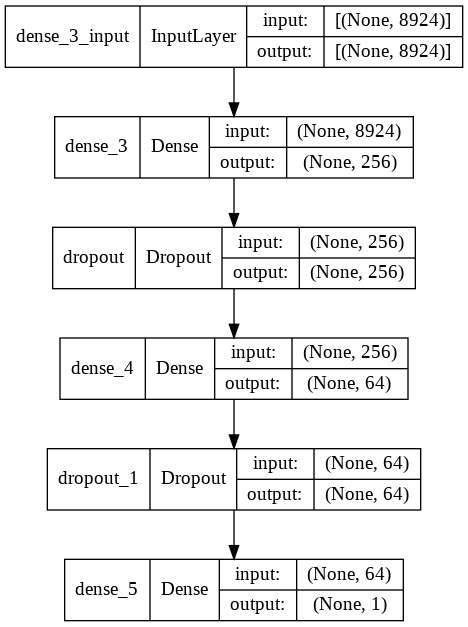

In [ ]:
keras.utils.plot_model(model, show_shapes = True, show_layer_names = True)

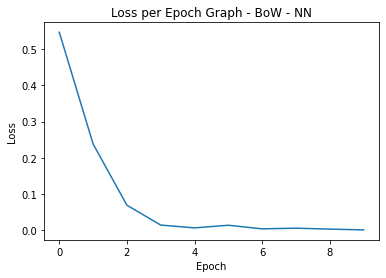

In [ ]:
import matplotlib.pyplot as plt

plt.title('Loss per Epoch Graph - BoW - NN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='loss')

plt.show()

*Feature Selection (2/3)*
# TF-IDF (Term Frequency - Inverse Document Frequency)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1, shuffle=True)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()

vectorizer.fit(X)
X_train = vectorizer.transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y)
y_train = le.transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

In [ ]:
X_train = X_train.toarray()
X_test = X_test.toarray()
X_val = X_val.toarray()

In [ ]:
dummy = pd.DataFrame(X_train)
dummy

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,8884,8885,8886,8887,8888,8889,8890,8891,8892,8893,8894,8895,8896,8897,8898,8899,8900,8901,8902,8903,8904,8905,8906,8907,8908,8909,8910,8911,8912,8913,8914,8915,8916,8917,8918,8919,8920,8921,8922,8923
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3703,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Neural Networks Model

In [ ]:
model = Sequential()
model.add(Dense(units=256, activation='relu', input_dim=len(vectorizer.get_feature_names_out())))
model.add(Dropout(0.2))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))
opt = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', f1_m, precision_m, recall_m])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F-1 Score:", f1_score)

Epoch 1/10
116/116 [==============================] - 3s 20ms/step - loss: 0.5584 - accuracy: 0.7042 - f1_m: 0.7849 - precision_m: 0.7215 - recall_m: 0.8829 - val_loss: 0.4740 - val_accuracy: 0.7670 - val_f1_m: 0.8242 - val_precision_m: 0.7863 - val_recall_m: 0.8711
Epoch 2/10
116/116 [==============================] - 2s 18ms/step - loss: 0.2348 - accuracy: 0.8982 - f1_m: 0.9179 - precision_m: 0.9073 - recall_m: 0.9346 - val_loss: 0.5305 - val_accuracy: 0.7454 - val_f1_m: 0.7911 - val_precision_m: 0.8310 - val_recall_m: 0.7596
Epoch 3/10
116/116 [==============================] - 2s 18ms/step - loss: 0.0696 - accuracy: 0.9746 - f1_m: 0.9789 - precision_m: 0.9798 - recall_m: 0.9790 - val_loss: 0.8137 - val_accuracy: 0.7530 - val_f1_m: 0.8059 - val_precision_m: 0.8055 - val_recall_m: 0.8128
Epoch 4/10
116/116 [==============================] - 2s 18ms/step - loss: 0.0206 - accuracy: 0.9919 - f1_m: 0.9931 - precision_m: 0.9943 - recall_m: 0.9923 - val_loss: 1.0616 - val_accuracy: 0.7724 

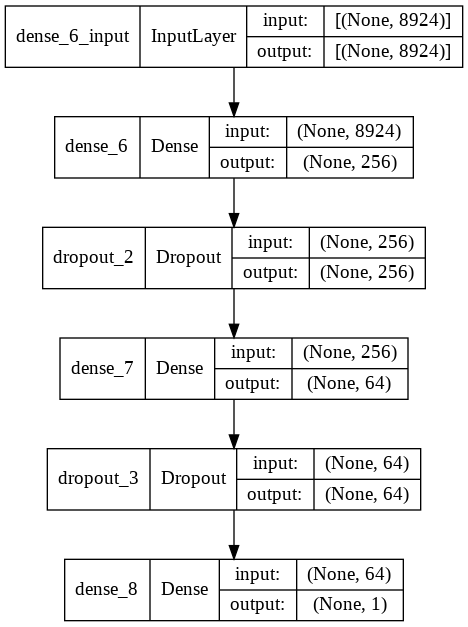

In [ ]:
keras.utils.plot_model(model, show_shapes = True, show_layer_names = True)

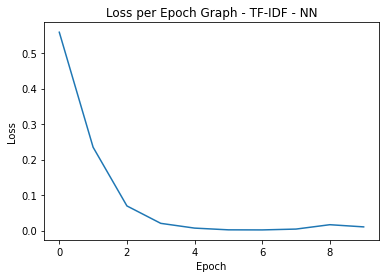

In [ ]:
import matplotlib.pyplot as plt

plt.title('Loss per Epoch Graph - TF-IDF - NN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='loss')

plt.show()

*Featre Selection (3/3)*
# One Hot Embedding

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1, shuffle=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y)
y_train = le.transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

In [ ]:
from keras.preprocessing.text import one_hot 

*Setting the vocabulary size as the number of our features*

In [ ]:
vocab_size = 10000

*Giving tokens to words according to our vocabulary size*

In [ ]:
#print(X_train[1])

from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)
#print(X_train[1])


user sorri innov thing aap done last 2yr chang size, shape, memori size, crappi map, & snippi siri.
[5, 776, 1112, 321, 1, 355, 75, 5155, 632, 626, 5156, 3341, 626, 5157, 3237, 5158, 3342]


In [ ]:
from keras.layers import Embedding
from keras.preprocessing.sequence import pad_sequences

*Finding out the maximum length of words that are present in a single sentence*

In [ ]:
max_length = max(len(x.split()) for x in X)
max_length

25

*Applying (post)padding to ensure all the rows has the same number of columns*

In [ ]:
X_train = pad_sequences(X_train, padding='post', maxlen = max_length)
X_val = pad_sequences(X_val, padding='post', maxlen = max_length)
X_test = pad_sequences(X_test, padding='post', maxlen = max_length)
X_train[0:10]

array([[ 336, 1179,  351,  291,   59,  541,  242,  742,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [   5,  776, 1112,  321,    1,  355,   75, 5155,  632,  626, 5156,
        3341,  626, 5157, 3237, 5158, 3342,    0,    0,    0,    0,    0,
           0,    0,    0],
       [  77, 5614,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [  29,  110,  235, 5629, 3310, 5630,  150,   49,  455, 1171,  235,
         201,   99,   40,  936,   52,  907, 1278,    0,    0,    0,    0,
           0,    0,    0],
       [   1, 1592,  486, 1236,  217,  355, 1056, 1261, 5632,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [ 109,  190,  259, 1118,  113, 2711,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,  

# Convolutional Neural Networks Model

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GlobalMaxPooling1D

embedding_dim = 200
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size = 2))
#model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
#model.add(Dropout(0.2))
#model.add(MaxPooling1D(pool_size = 2))
#model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
#model.add(Dropout(0.2))
#model.add(MaxPooling1D(pool_size = 2))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Dropout(0.2))
model.add(GlobalMaxPooling1D())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
opt = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', f1_m, precision_m, recall_m])
history = model.fit(X_train, y_train,  validation_data=(X_val, y_val), epochs=10)
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F-1 Score:", f1_score)


Epoch 1/10
116/116 [==============================] - 7s 51ms/step - loss: 0.6091 - accuracy: 0.6626 - f1_m: 0.7376 - precision_m: 0.6828 - recall_m: 0.8511 - val_loss: 0.5296 - val_accuracy: 0.7411 - val_f1_m: 0.7942 - val_precision_m: 0.8027 - val_recall_m: 0.7946
Epoch 2/10
116/116 [==============================] - 6s 49ms/step - loss: 0.4261 - accuracy: 0.7927 - f1_m: 0.8406 - precision_m: 0.8115 - recall_m: 0.8870 - val_loss: 0.5076 - val_accuracy: 0.7659 - val_f1_m: 0.8108 - val_precision_m: 0.8312 - val_recall_m: 0.7987
Epoch 3/10
116/116 [==============================] - 6s 49ms/step - loss: 0.2410 - accuracy: 0.8999 - f1_m: 0.9187 - precision_m: 0.9288 - recall_m: 0.9135 - val_loss: 0.5566 - val_accuracy: 0.7368 - val_f1_m: 0.7845 - val_precision_m: 0.8161 - val_recall_m: 0.7641
Epoch 4/10
116/116 [==============================] - 6s 49ms/step - loss: 0.1384 - accuracy: 0.9511 - f1_m: 0.9609 - precision_m: 0.9574 - recall_m: 0.9669 - val_loss: 0.5949 - val_accuracy: 0.7033 

In [ ]:
model.summary() 

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 25, 200)           2000000   
                                                                 
 conv1d_35 (Conv1D)          (None, 23, 256)           153856    
                                                                 
 dropout_41 (Dropout)        (None, 23, 256)           0         
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 11, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_36 (Conv1D)          (None, 9, 32)             24608     
                                                                 
 dropout_42 (Dropout)        (None, 9, 32)             0         
                                                     

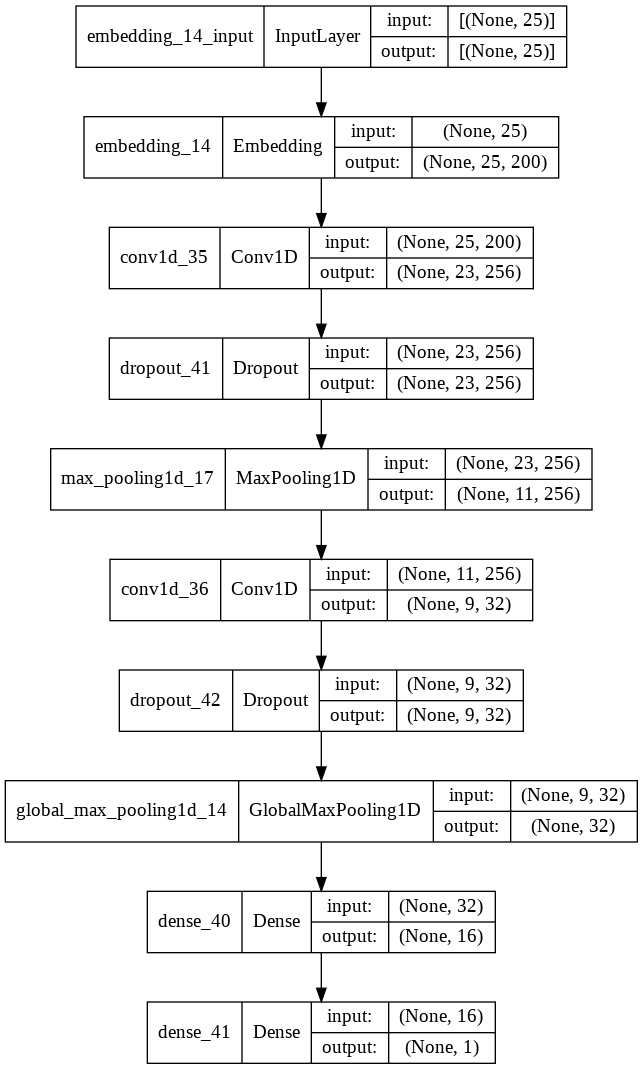

In [ ]:
keras.utils.plot_model(model, show_shapes = True, show_layer_names = True)

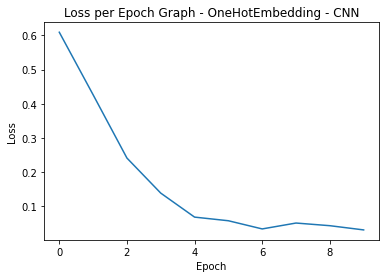

In [ ]:
import matplotlib.pyplot as plt

plt.title('Loss per Epoch Graph - OneHotEmbedding - CNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='loss')

plt.show()